# Runtime tests

In this notebook I am testing the runtime of the observing window calculation with different setups.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import seaborn as sns

## Tests after code improvements

I worked out several runtime improvements for the calculation of observing windows. For each sequential improvement I ran timing tests with a small field grid setup (1056 Northern fields, 517 Southern fields). Each test was repeated four times.

### Effects of code improvement tested on laptop

#### Load results

These tests ran on a 6-core laptop. The tests correspond to the following code versions:

- t0: Code before runtime improvements.
- t1: Batch writing of observing windows to database.
- t2: Constraint calculation improvement (removed unnecessary calculations of further constraints, when it was already known that a source is not visible at a certain time due to previously calculated constraints).
- t3: Restructuring code order which removed many redundant calculations and parallelization. The tag suffixes `-x` refer to the number of cores used for the calculation, e.g. `t3-1` just used a single core for the observing window calculation.
- t4: MoonDistance constraint improvement (refinement calculations do not overwrite the saved frame and Moon positions, which avoids recalculation for all fields). The tag suffixes `-x` are the same as in test `t3`.

Note that each test is running for the incremental code versions. I.e. each code version includes all previous improvements.

In [2]:
tests = pd.read_csv('runtime_tests_1_testsetup_local.dat', names=('test', 'id', 'runtime (days)'), skiprows=1)
tests['runtime (min)'] = tests['runtime (days)'] * 24 * 60
tests

,test,id,runtime (days),runtime (min)
0,t0,0,0.010474,15.083117
1,t0,1,0.010393,14.966165
2,t0,2,0.010440,15.033928
3,t0,3,0.010291,14.819333
4,t1,0,0.009588,13.807204
5,t1,1,0.009590,13.808921
6,t1,2,0.009584,13.801473
7,t1,3,0.009589,13.808802
8,t2,0,0.008539,12.296768
9,t2,1,0.008528,12.279934


Group by code version and calculate the median runtime. Then calculate the fractional runtime relative to the initial code version and relative to the previous code version, similarly the runtime reduction:

In [3]:
tests_median = tests.drop(columns='id').groupby(by='test').median().reset_index()
tests_median['fraction_v0'] = tests_median['runtime (min)'] / tests_median.loc[0, 'runtime (min)']
tests_median['reduction_v0'] = 1 - tests_median['fraction_v0']
tests_median['fraction_incr'] = [np.nan] + [tests_median.loc[i, 'runtime (min)'] / tests_median.loc[i-1, 'runtime (min)'] for i in range(1, tests_median.shape[0])]
# manual fix to compare v4-1 with v3-1 and not v3-6:
tests_median.at[7, 'fraction_incr'] = tests_median.at[7, 'runtime (min)'] / tests_median.at[3, 'runtime (min)']
tests_median['reduction_incr'] = 1 - tests_median['fraction_incr']
tests_median

,test,runtime (days),runtime (min),fraction_v0,reduction_v0,fraction_incr,reduction_incr
0,t0,0.010417,15.000046,1.000000,0.000000,NaN,NaN
1,t1,0.009589,13.808003,0.920531,0.079469,0.920531,0.079469
2,t2,0.008540,12.297566,0.819835,0.180165,0.890611,0.109389
3,t3-1,0.005031,7.245113,0.483006,0.516994,0.589150,0.410850
4,t3-2,0.002908,4.187724,0.279181,0.720819,0.578007,0.421993
5,t3-4,0.001779,2.561241,0.170749,0.829251,0.611607,0.388393
6,t3-6,0.001564,2.252854,0.150190,0.849810,0.879595,0.120405
7,t4-1,0.003918,5.642088,0.376138,0.623862,0.778744,0.221256
8,t4-2,0.002335,3.361748,0.224116,0.775884,0.595834,0.404166
9,t4-4,0.001452,2.090697,0.139379,0.860621,0.621908,0.378092


#### Show results

##### Runtime

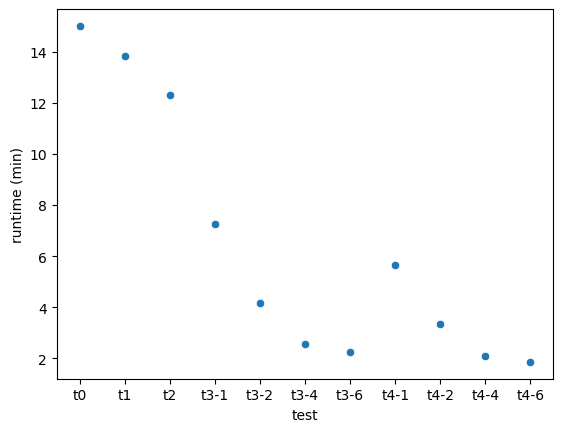

In [4]:
sns.scatterplot(data=tests_median, x='test', y='runtime (min)');

##### Fractional runtime relative to initial version

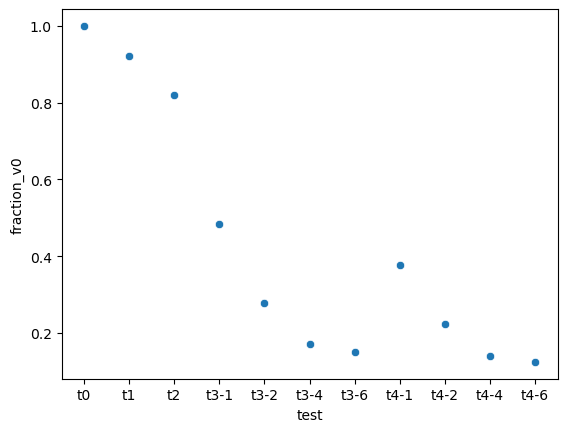

In [5]:
sns.scatterplot(data=tests_median, x='test', y='fraction_v0');

##### Fractional runtime reduction relative to initial version

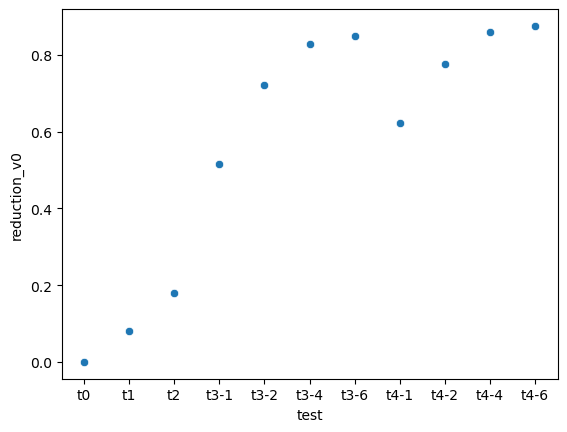

In [6]:
sns.scatterplot(data=tests_median, x='test', y='reduction_v0');

##### Fractional runtime reduction relative to previous version

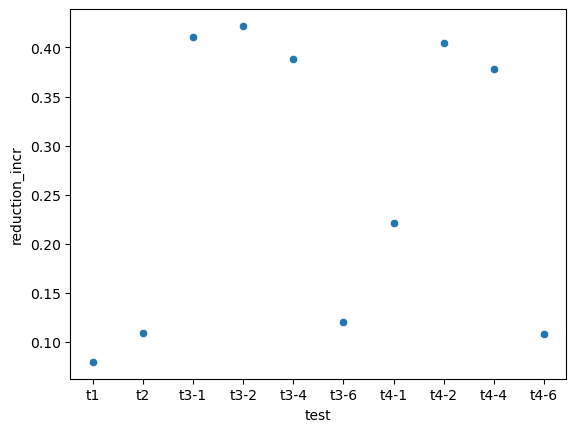

In [7]:
sns.scatterplot(data=tests_median, x='test', y='reduction_incr');

#### Notes

* Each revision resulted in a substantial reduction of the runtime. Most productive were the removal of redundant repetitions as part of the parallelization (v2 to v3) and avoiding the recalculation of the Moon position (v3 to v4).
* Moving from 1 to 2 processes had the biggest impact.
* Adding more processes decreases the runtime, but the relative improvement becomes smaller with every process added. However, this is likely system dependent. I ran these tests on the institute's laptop which has 6 cores. I guess that the OS managing the processes cuts away substantial resources, which is why the incremental improvements become smaller. On a cluster the improvement may be much stronger and I need to test this once I get access, before I run the code on the actual field grid setup.

### Tests on kallisto

#### Load results

These tests ran on a 64-core cluster `kallisto`. The tests all run the final code version corresponing to `t4` above. The number after the dash corresponds to the number of processes used for the observing window calculation.

In [9]:
tests = pd.read_csv('runtime_tests_2_testsetup_kallisto.dat', names=('processes', 'id', 'runtime (days)'), skiprows=1)
tests['runtime (min)'] = tests['runtime (days)'] * 24 * 60
tests

,processes,id,runtime (days),runtime (min)
0,1,0,0.001934,2.784698
1,1,1,0.001916,2.759757
2,1,2,0.001917,2.760359
3,1,3,0.001915,2.757746
4,2,0,0.001087,1.565673
5,2,1,0.001082,1.557960
6,2,2,0.001083,1.559065
7,2,3,0.001081,1.556544
8,4,0,0.000647,0.931950
9,4,1,0.000642,0.924492


Group by code version and calculate the median runtime. Then calculate the fractional runtime relative to the initial code version and relative to the previous code version, similarly the runtime reduction:

In [10]:
tests_median = tests.drop(columns='id').groupby(by='processes').median().reset_index()
tests_median['fraction_v0'] = tests_median['runtime (min)'] / tests_median.loc[0, 'runtime (min)']
tests_median['reduction_v0'] = 1 - tests_median['fraction_v0']
tests_median['fraction_incr'] = [np.nan] + [tests_median.loc[i, 'runtime (min)'] / tests_median.loc[i-1, 'runtime (min)'] for i in range(1, tests_median.shape[0])]
tests_median['reduction_incr'] = 1 - tests_median['fraction_incr']
tests_median

,processes,runtime (days),runtime (min),fraction_v0,reduction_v0,fraction_incr,reduction_incr
0,1,0.001917,2.760058,1.000000,0.000000,NaN,NaN
1,2,0.001082,1.558513,0.564667,0.435333,0.564667,0.435333
2,4,0.000645,0.928221,0.336305,0.663695,0.595581,0.404419
3,6,0.000514,0.740623,0.268336,0.731664,0.797896,0.202104
4,8,0.000457,0.658164,0.238460,0.761540,0.888662,0.111338
5,10,0.000387,0.557942,0.202149,0.797851,0.847725,0.152275
6,20,0.000351,0.504754,0.182878,0.817122,0.904670,0.095330


#### Show results

##### Runtime

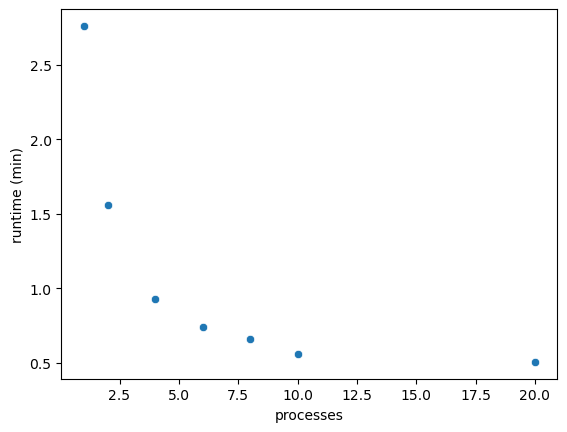

In [11]:
sns.scatterplot(data=tests_median, x='processes', y='runtime (min)');

##### Fractional runtime relative to initial version

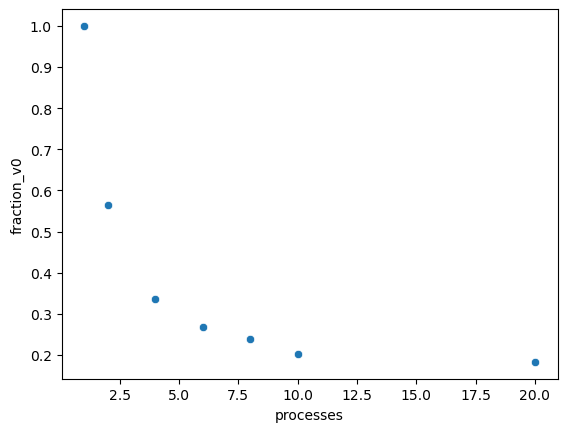

In [12]:
sns.scatterplot(data=tests_median, x='processes', y='fraction_v0');

##### Fractional runtime reduction relative to initial version

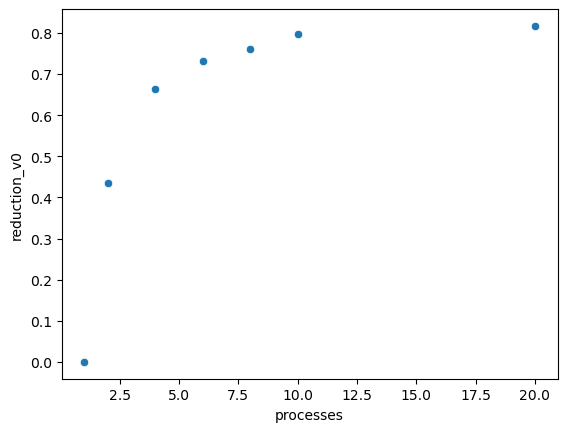

In [13]:
sns.scatterplot(data=tests_median, x='processes', y='reduction_v0');

##### Fractional runtime reduction relative to previous version

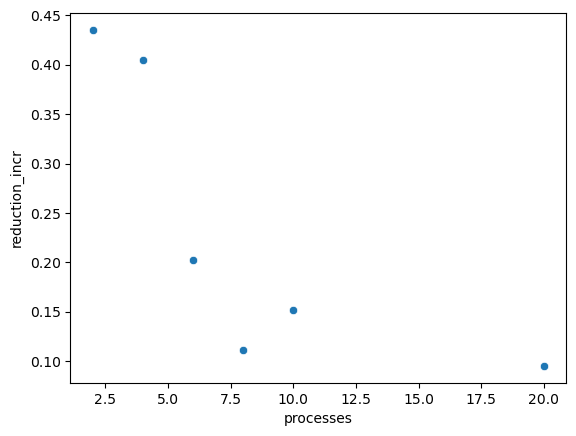

In [14]:
sns.scatterplot(data=tests_median, x='processes', y='reduction_incr');

### Full grid tests on kallisto

These tests use the full Pasiphae survey field grid with all relevant observational constraints. The goal of these tests is to check which number of processes is reasonable to use.

#### Load results

In [15]:
tests = pd.read_csv('runtime_tests_3_fullgrid_kallisto.dat', names=('processes', 'id', 'runtime (days)'), skiprows=1)
tests['runtime (min)'] = tests['runtime (days)'] * 24 * 60
tests

,processes,id,runtime (days),runtime (min)
0,5,0,0.027498,39.597271
1,10,0,0.014516,20.903031
2,15,0,0.010307,14.842480
3,20,0,0.008514,12.260551
4,25,0,0.008358,12.035375
5,30,0,0.007613,10.962311


Group by code version and calculate the median runtime. Then calculate the fractional runtime relative to the initial code version and relative to the previous code version, similarly the runtime reduction:

In [16]:
tests_median = tests.drop(columns='id').groupby(by='processes').median().reset_index()
tests_median['fraction_v0'] = tests_median['runtime (min)'] / tests_median.loc[0, 'runtime (min)']
tests_median['reduction_v0'] = 1 - tests_median['fraction_v0']
tests_median['fraction_incr'] = [np.nan] + [tests_median.loc[i, 'runtime (min)'] / tests_median.loc[i-1, 'runtime (min)'] for i in range(1, tests_median.shape[0])]
tests_median['reduction_incr'] = 1 - tests_median['fraction_incr']
tests_median

,processes,runtime (days),runtime (min),fraction_v0,reduction_v0,fraction_incr,reduction_incr
0,5,0.027498,39.597271,1.000000,0.000000,NaN,NaN
1,10,0.014516,20.903031,0.527891,0.472109,0.527891,0.472109
2,15,0.010307,14.842480,0.374836,0.625164,0.710064,0.289936
3,20,0.008514,12.260551,0.309631,0.690369,0.826045,0.173955
4,25,0.008358,12.035375,0.303945,0.696055,0.981634,0.018366
5,30,0.007613,10.962311,0.276845,0.723155,0.910841,0.089159


#### Show results

##### Runtime

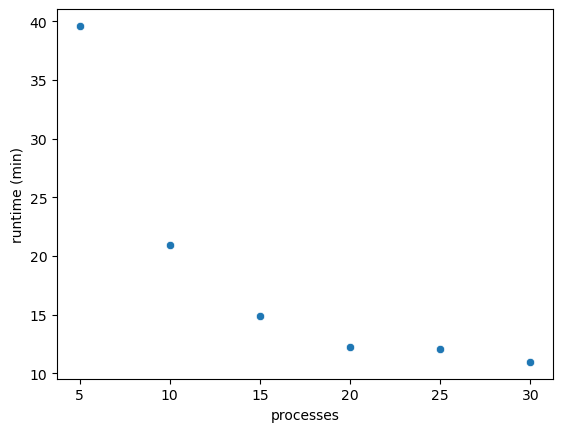

In [17]:
sns.scatterplot(data=tests_median, x='processes', y='runtime (min)');

##### Fractional runtime relative to initial version

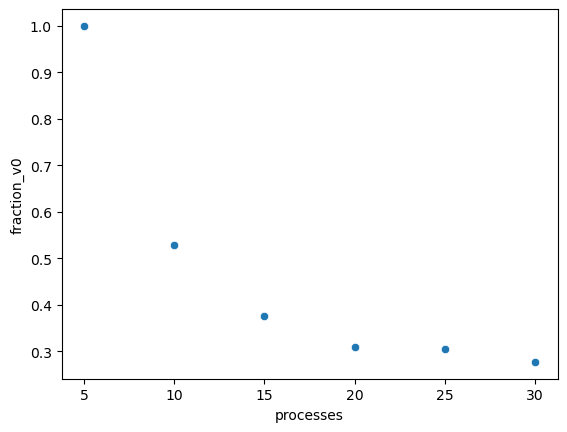

In [18]:
sns.scatterplot(data=tests_median, x='processes', y='fraction_v0');

##### Fractional runtime reduction relative to initial version

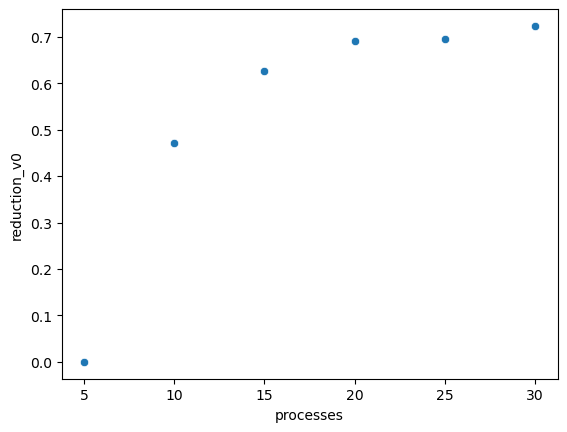

In [19]:
sns.scatterplot(data=tests_median, x='processes', y='reduction_v0');

##### Fractional runtime reduction relative to previous version

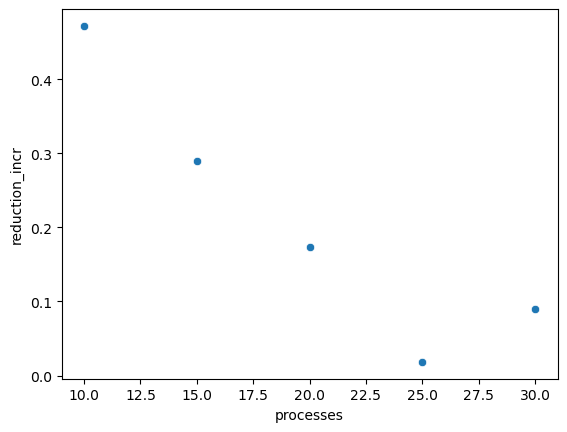

In [20]:
sns.scatterplot(data=tests_median, x='processes', y='reduction_incr');

## Tests after code revision (March 2024)

I moved the observability status calculations from the priorization to the observability calculation part, i.e. the status is now pre-calculated and stored in the data base. The idea behind that was that this reduces the runtime of my strategy tests, because the status does not have to be calculated over and over again for each strategy test. As part of this code revision I also discovered and fixed a bug in the code that affected the previous status calculation. I furthermore found that a higher precession in the initial and refined time grid may be needed to calculate the status reliably. Finer time grids would increase the runtime however. I cannot directly compare the new code's runtime to the previous version above, because previously I did not take any notes on the specifications of the runtime tests (e.g. for what dates, for how many days did I run the tests). Too bad, I will do these tests in a systematic, well documented way now. But I cannot repeat the tests above.

### Test grid setup

In [2]:
tests = pd.concat(
        [pd.read_csv('runtime_tests_4_testsetup_local.dat').rename(columns={
                '#computer': 'computer', 'runtime_total (days)': 'runtime (days)'}),
        pd.read_csv('runtime_tests_4_testsetup_kallisto.dat').rename(columns={
                '#computer': 'computer', 'runtime_total (days)': 'runtime (days)'})],
        ignore_index=True)
tests['runtime (min)'] = tests['runtime (days)'] * 24 * 60

Drop all test information that does not change, group by initial and refined time interval and calculate the median runtime. Invert the order of tests to start with the most coarse initial and refinement time grid. Then calculate the fractional runtime relative to the first test setup:

In [3]:
tests = tests.groupby(by=['computer', 'date_start', 'date_stop', 'n_days', 'time_interval_init', 'time_interval_refine', 'processes', 'batch_write']).median().reset_index()
tests.drop(columns=['test_id'], inplace=True)
tests

,computer,date_start,date_stop,n_days,time_interval_init,time_interval_refine,processes,batch_write,runtime (days),runtime (min)
0,kallisto,2024-01-01,2024-01-02,1,300,10,1,100,0.001705,2.455161
1,kallisto,2024-01-01,2024-01-02,1,300,10,1,500,0.001715,2.470005
2,kallisto,2024-01-01,2024-01-02,1,300,10,1,1000,0.001704,2.453342
3,kallisto,2024-01-01,2024-01-02,1,300,10,2,100,0.001330,1.915486
4,kallisto,2024-01-01,2024-01-02,1,300,10,2,500,0.001339,1.928856
...,...,...,...,...,...,...,...,...,...,...
67,laptop_linux,2024-01-01,2024-01-02,1,600,60,1,500,0.001360,1.959001
68,laptop_linux,2024-01-01,2024-01-02,1,600,60,1,1000,0.001359,1.957357
69,laptop_linux,2024-01-01,2024-01-02,1,600,60,2,100,0.000769,1.107467
70,laptop_linux,2024-01-01,2024-01-02,1,600,60,2,500,0.000760,1.094243


#### Effect of time grid choices

In [4]:
time_interval_tag = [f'{t_init}-{t_refine}' for t_init, t_refine in zip(tests['time_interval_init'], tests['time_interval_refine'])]
tests['time_interval_tag'] = time_interval_tag
del time_interval_tag

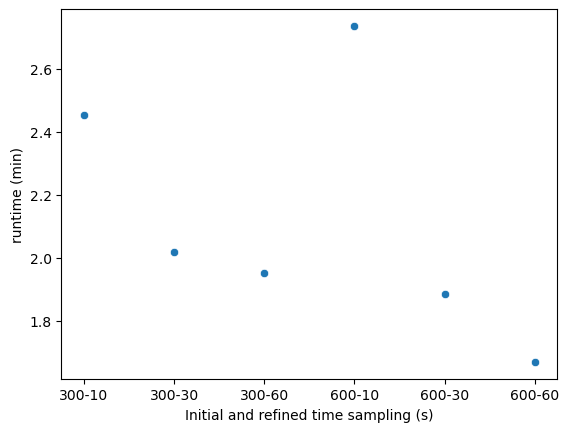

In [5]:
sel = np.logical_and.reduce([
        tests['computer'] == 'kallisto', 
        tests['batch_write'] == 1000, 
        tests['processes'] == 1])
sns.scatterplot(data=tests.loc[sel], x='time_interval_tag', y='runtime (min)')
plt.xlabel('Initial and refined time sampling (s)');

**Note:** This test was also done in `Develop_ObservabilityStatusUpdate.ipynb`. 

**Results:**
- As expected, a coarser time grid requires less computing time.
- An initial time interval of 600 seconds and a refined interval of 60 seconds gives us good enough precision, as discussed in `Develop_ObservabilityStatusUpdate.ipynb`. 
- Finer grids result in an increase of computing time by a substantial factor. Therefore, we will use 600-60.

In [6]:
del tests['time_interval_tag']

#### Effect of number of processes

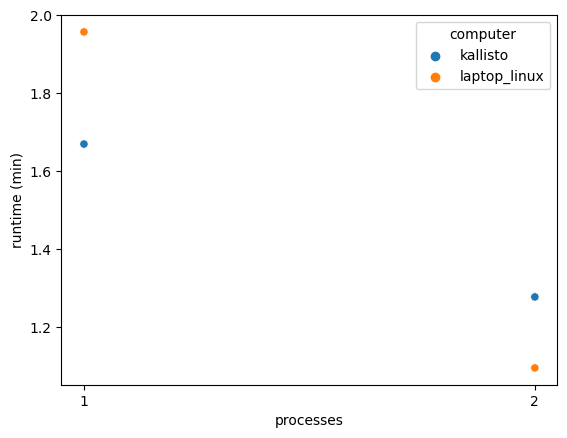

In [7]:
sel = np.logical_and.reduce([
        #tests['computer'] == 'kallisto',
        tests['time_interval_init'] == 600,
        tests['time_interval_refine'] == 60,
        tests['batch_write'] == 1000])
sns.scatterplot(data=tests.loc[sel], x='processes', y='runtime (min)', hue='computer')
plt.gca().xaxis.set_major_locator(MultipleLocator(1));

**Results:**
- Going from 1 to 2 processes almost reduces the computing time by a factor of 2 on my laptop. The time gain is substantially smaller on kallisto.

#### Effect of batch writing

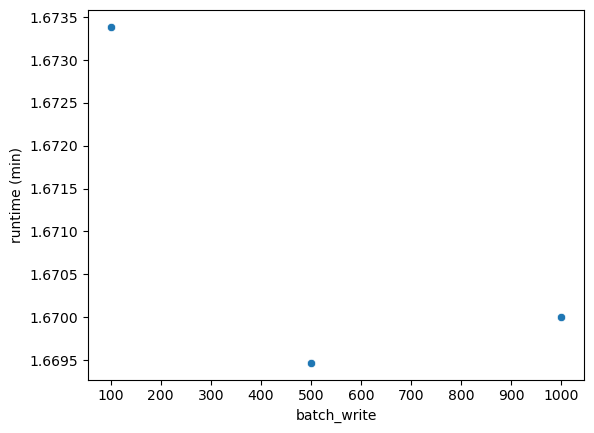

In [8]:
sel = np.logical_and.reduce([
        tests['computer'] == 'kallisto',
        tests['time_interval_init'] == 600,
        tests['time_interval_refine'] == 60,
        tests['processes'] == 1,
        ])
sns.scatterplot(data=tests.loc[sel], x='batch_write', y='runtime (min)')
plt.gca().xaxis.set_major_locator(MultipleLocator(100));

**Results:**
- The differences in the run time are on the time scale of seconds. Therefore, the choice of `batch_write` does not have a substantial effect.
- In this test setup the Northern and Southern field grids consist of about 1000 fields each. Therefore, with `batch_write=1000` all entries are written at the end. This explains why the runtime is than with `batch_write=500`, where about half of the entries are written half way through the calculations.
- Concluding, to optimize runtime `batch_write` should be chosen based on the number of fields. Therefore, this should not even be a free parameter, but decided by the program. However, the over-all effect is negligible.

### Full grid setup

I ran these tests only on kallisto, because on my laptop with just one or two processes this would take too long.

In [4]:
tests = pd.read_csv('runtime_tests_5_fullgrid_kallisto.dat').rename(columns={
                '#computer': 'computer', 'runtime_total (days)': 'runtime (days)'})
tests['runtime (min)'] = tests['runtime (days)'] * 24 * 60

Drop all test information that does not change, group by initial and refined time interval and calculate the median runtime. Invert the order of tests to start with the most coarse initial and refinement time grid. Then calculate the fractional runtime relative to the first test setup:

In [5]:
tests = tests.groupby(by=['computer', 'date_start', 'date_stop', 'n_days', 'time_interval_init', 'time_interval_refine', 'processes', 'batch_write']).median().reset_index()
tests.drop(columns=['test_id'], inplace=True)
tests

,computer,date_start,date_stop,n_days,time_interval_init,time_interval_refine,processes,batch_write,runtime (days),runtime (min)
0,kallisto,2024-01-01,2024-01-02,1,600,60,10,1000,0.080516,115.943427
1,kallisto,2024-01-01,2024-01-02,1,600,60,10,10000,0.080422,115.807630
2,kallisto,2024-01-01,2024-01-02,1,600,60,10,20000,0.080257,115.569417
3,kallisto,2024-01-01,2024-01-02,1,600,60,20,1000,0.077914,112.196191
4,kallisto,2024-01-01,2024-01-02,1,600,60,20,10000,0.078248,112.677677
5,kallisto,2024-01-01,2024-01-02,1,600,60,20,20000,0.078485,113.018578


#### Effect of number of processes

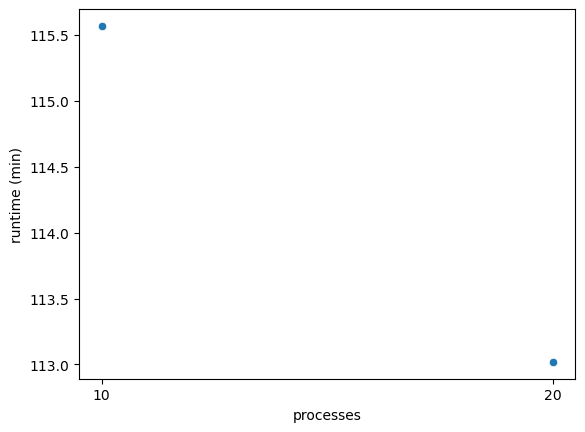

In [6]:
sel = tests['batch_write'] == 20000
sns.scatterplot(data=tests.loc[sel], x='processes', y='runtime (min)')
plt.gca().xaxis.set_major_locator(MultipleLocator(10));

#### Effect of batch writing

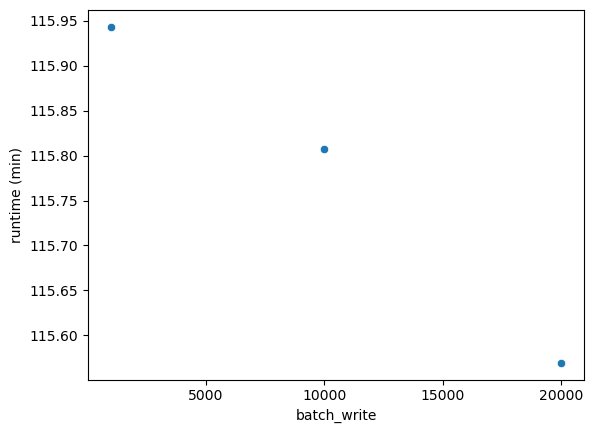

In [7]:
sel = tests['processes'] == 10
sns.scatterplot(data=tests.loc[sel], x='batch_write', y='runtime (min)')
plt.gca().xaxis.set_major_locator(MultipleLocator(5000));

**Results:**
- The differences in the run time are on the time scale of less than a minute. Therefore, the choice of `batch_write` does not have a substantial effect.
- In this full grid setup the Northern and Southern field grids consist of about 83000 nd 61000 fields. Therefore, I am not reaching the optimization limit as it was the case above. 